### Working through David Ha's Mixture Density Networks Post in Pytorch
Please refer to David's original post in Tensorflow:  http://otoro.net/ml/ipynb/mixture/mixture.html

He gives a great introduction to MDN's with detailed explanation. In this notebook, I simply walk through his post, replacing tensorflow with pytorch. 



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import time
import math
import os, sys
import torch
import torch.nn as nn
from torch.nn.utils.clip_grad import clip_grad_norm
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
from IPython import embed
import shutil
import torch
import torch.nn as nn
from torch.autograd import Variable
rdn = np.random.RandomState(33)
_ = torch.manual_seed(12)

In [2]:
NHIDDEN = 24
lossfunc = nn.MSELoss()

### Predict Y given X

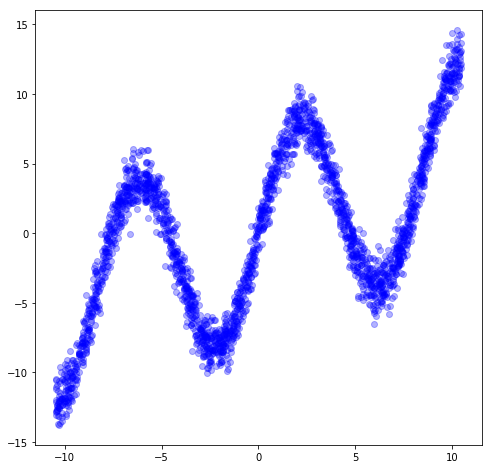

In [3]:
NSAMPLE = 2500
# INPUT DATA x,y
x_data = Variable(torch.FloatTensor(np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T))
r_data = Variable(torch.FloatTensor(np.float32(np.random.normal(size=(NSAMPLE,1))))) # random noise
y_data = Variable(torch.FloatTensor(np.float32(np.sin(0.75*x_data)*7.0+x_data*0.5+r_data*1.0)))

x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = Variable(torch.FloatTensor(x_test.reshape(x_test.size,1)))


plt.figure(figsize=(8, 8))
plt.plot(x_data.data.numpy(),y_data.data.numpy(),'bo', alpha=0.3)
plt.show()

In [4]:
class ExampleFeedforward(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(ExampleFeedforward, self).__init__()
        self.linear = nn.Linear(n_input, n_hidden)
        self.hidden = nn.Linear(n_hidden, n_output)
    def forward(self,x):
        o = torch.tanh(self.linear(x))
        oo = self.hidden(o)
        return oo

In [5]:
eFF = ExampleFeedforward(1,NHIDDEN,1)
optim = torch.optim.Adam(eFF.parameters(), lr=0.01)

In [6]:
losses = []
for e in range(5000):
    o = eFF(x_data)
    loss = lossfunc(y_data,o)
    losses.append(loss)
    loss.backward()
    optim.step()
    eFF.zero_grad()

Text(0.5,1,'training loss')

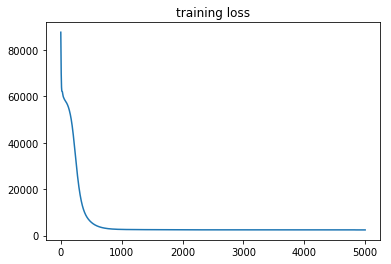

In [7]:
plt.plot(losses)
plt.title("training loss")

In [8]:
y_test_predict = eFF(x_test)

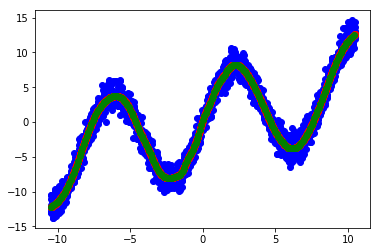

In [9]:
plt.plot(x_data.data.numpy(), y_data.data.numpy(), 'bo')
plt.plot(x_data.data.numpy(), o.data.numpy(), 'ro')
plt.plot(x_test.data.numpy(), y_test_predict.data.numpy(), 'go')

### What if there are many possible Y for a given X (one to many)? 

Text(0.5,1,'dataset with many possible y for given x')

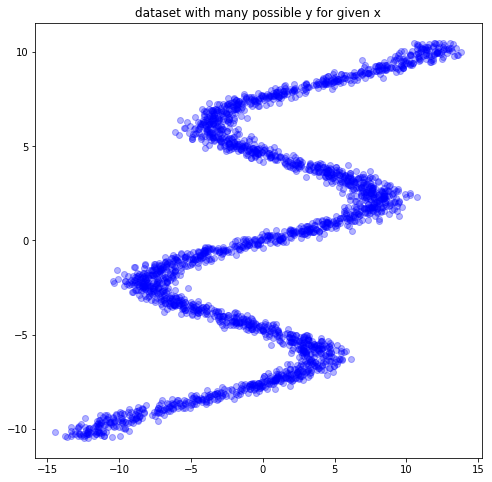

In [10]:
my_data = Variable(torch.FloatTensor(np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T))
mr_data = Variable(torch.FloatTensor(np.float32(np.random.normal(size=(NSAMPLE,1))))) # random noise
mx_data = Variable(torch.FloatTensor(np.float32(np.sin(0.75*my_data)*7.0+my_data*0.5+mr_data*1.0)))

mx_test = np.float32(np.arange(-10.5,10.5,0.1))
mx_test = Variable(torch.FloatTensor(mx_test.reshape(mx_test.size,1)))

plt.figure(figsize=(8, 8))
plot_out = plt.plot(mx_data.data.numpy(),my_data.data.numpy(),'bo',alpha=0.3)
plt.title("dataset with many possible y for given x")

Text(0.5,1,'training loss')

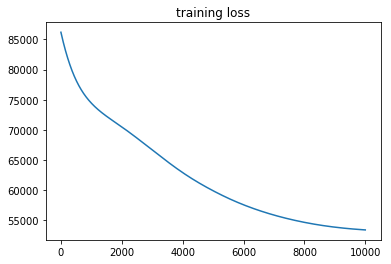

In [11]:
meFF = ExampleFeedforward(1,NHIDDEN,1)
moptim = torch.optim.Adam(meFF.parameters(), lr=1e-4)
mlosses = []
for e in range(10000):
    mo = meFF(mx_data)
    mloss = lossfunc(my_data,mo)
    mloss.backward()
    mlosses.append(mloss)
    moptim.step()
    meFF.zero_grad()
plt.plot(mlosses)
plt.title("training loss")

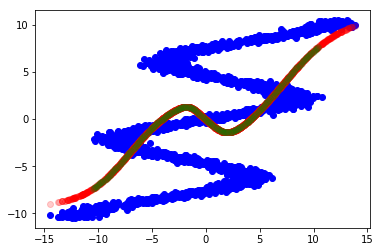

In [12]:
my_test_predict = meFF(mx_test)
plt.plot(mx_data.data.numpy(), my_data.data.numpy(), 'bo')
plt.plot(mx_data.data.numpy(), mo.data.numpy(), 'ro',alpha=.2 )
plt.plot(mx_test.data.numpy(), my_test_predict.data.numpy(), 'go', alpha=.2)

### Mixture Density Networks to the Rescue

In [13]:
STDEV = 0.5
NHIDDEN = 24
KMIX = 24 # number of mixtures
NOUT = KMIX*3 # one each for pi, mean, stdev
mdx_test = Variable(torch.FloatTensor(np.float32(np.arange(-15,15,0.1))[:,None]))
NTEST = x_test.shape[0]

In [14]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def get_mixture_coef(output):
    split_pi, out_sigma, out_mu = torch.split(output, KMIX, dim=1)
    max_pi,_ = torch.max(split_pi, dim=1, keepdim=True)
    exp_pi = torch.exp(split_pi-max_pi)
    norm_pi = torch.sum(exp_pi, dim=1, keepdim=True)
    out_pi =  exp_pi/norm_pi 
    out_sigma = torch.exp(out_sigma)
    return out_pi, out_sigma, out_mu

def pt_normal(y,mu,sigma):
    result = (y-mu)/sigma
    result = -(result**2)/2.0
    result = (torch.exp(result)/sigma)*oneDivSqrtTwoPI
    return result

def get_lossfunc(out_pi, out_sigma, out_mu, y):
    result = pt_normal(y, out_mu, out_sigma)
    result = result*out_pi
    result = torch.sum(result, dim=1, keepdim=True)
    result = -torch.log(result)
    return torch.mean(result)

torch.Size([2500, 72])


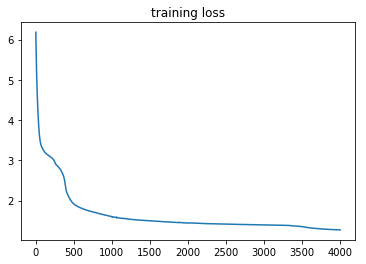

In [15]:
mdeFF = ExampleFeedforward(1,NHIDDEN,NOUT)
mdoptim = torch.optim.Adam(mdeFF.parameters(), lr=1e-3)
mdlosses = []
for e in range(4000):
    mdo = mdeFF(mx_data)
    out_pi, out_sigma, out_mu = get_mixture_coef(mdo)
    mdloss = get_lossfunc(out_pi, out_sigma, out_mu, my_data)
    mdloss.backward()
    mdlosses.append(mdloss)
    mdoptim.step()
    mdeFF.zero_grad()
plt.plot(mdlosses)
plt.title("training loss")
print(mdo.shape)

In [16]:
split_pi, out_sigma, out_mu = torch.split(mdo, KMIX, dim=1)

In [19]:
my_data.shape

torch.Size([2500, 1])

In [16]:
def get_pi_idx(x, pdf):
    npdf = pdf.shape[0]
    accumulate = 0
    for i in range(npdf):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    print('error with sampling ensemble')
    return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M=10):
    NTEST = out_pi_test.shape[0]
    result = np.random.rand(NTEST, M) # initially random [0, 1]
    rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
    mu = 0; std = 0; idx = 0
    # transforms result into random ensembles
    for j in range(M):
        for i in range(NTEST):
            idx = get_pi_idx(result[i, j], out_pi[i])
            mu = out_mu[i, idx]
            std = out_sigma[i, idx]
            result[i, j] = mu + rn[i, j]*std
    return result


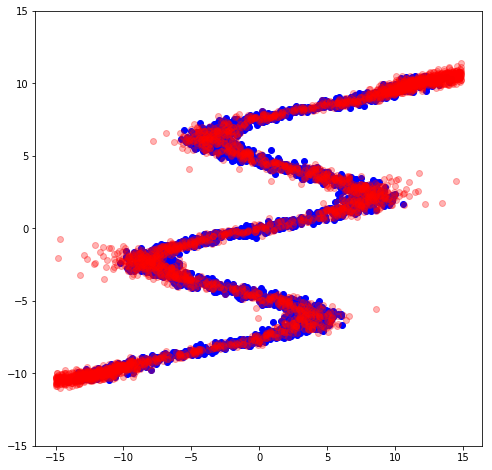

In [17]:
mdo = mdeFF(mdx_test)
out_pi_test, out_sigma_test, out_mu_test = get_mixture_coef(mdo)

mdy_test = generate_ensemble(out_pi_test.data.numpy(), out_mu_test.data.numpy(), out_sigma_test.data.numpy())

plt.figure(figsize=(8, 8))
plt.plot(mx_data.data.numpy(), my_data.data.numpy(),'bo')
plt.plot(mdx_test.data.numpy(), mdy_test,'ro',alpha=0.3)
plt.ylim([-15,15])
plt.show()

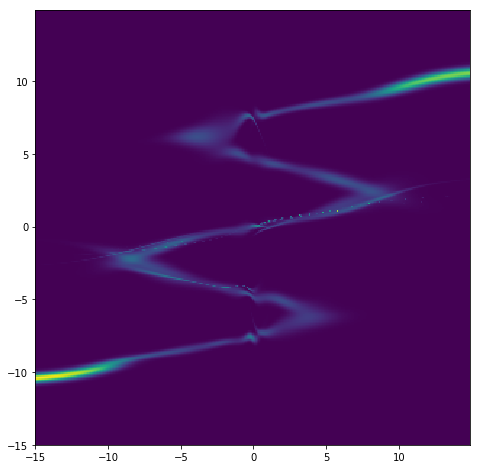

In [18]:
x_heatmap_label = np.float32(np.arange(-15,15,0.1))
y_heatmap_label = np.float32(np.arange(-15,15,0.1))

def custom_gaussian(x, mu, std):
    x_norm = (x-mu)/std
    result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
    return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
    N = x_heatmap_label.size
    M = y_heatmap_label.size
    K = KMIX

    z = np.zeros((N, M)) # initially random [0, 1]

    mu = 0; std = 0; pi = 0

    # transforms result into random ensembles
    for k in range(0, K):
        for i in range(0, M):
            pi = out_pi[i, k]
            mu = out_mu[i, k]
            std = out_sigma[i, k]
            for j in range(0, N):
                z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

    return z

def draw_heatmap(xedges, yedges, heatmap):
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap, extent=extent)
    plt.show()

z = generate_heatmap(out_pi_test.data, out_mu_test.data, out_sigma_test.data, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)